In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

import utils2.testing_gen as gen
import utils2.loading as load
import utils2.nn_gen as nn_gen
from utils2.tools import array2List

from NNSimulator import genSim, getSimulationData


from norm import normalizeGraph

from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader


yessss sir
>>>>>>>>>>>> LOADOING THE V2 OF FEATURES
fndjngkjdfs --NN-sim
update


In [2]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [3]:
import stats.stats_re as stats
import yaml

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

PATH = ['/home/jpierre/v2/results_end/files/roll/gnn']
MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = 'compex'

In [5]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [6]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(MODEL, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [7]:
class id():
    def __init__(self):
        self.nbLayer = None
        self.dropout = None
        self.layerNorm = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            nb_layer_match = re.search(r'nbLyaer-(\d+)', path)
            dropout_match = re.search(r'dropout-(\d+)', path)
            layer_norm_match = re.search(r'layerNorm-(\d+)', path)

            self.nbLayer = int(nb_layer_match.group(1))
            self.dropout = int(dropout_match.group(1))
            self.layerNorm = int(layer_norm_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_nbLayer-{self.nbLayer}_dropout{self.dropout}_layerNorm{self.layerNorm}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    res.extend(get_path_models(path))

In [8]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/compex_best.pt >>> {'nbLayer': 1, 'dropout': 0, 'layerNorm': 1, 'path': '/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/compex_best.pt', 'loss': '/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'cfg': '/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-1_dropout-0_layerNorm-1/cfg.yml'}
/home/jpierre/v2/results_end/files/roll/gnn/mt_compex_noisy_nbLyaer-2_dropout-0_layerNorm-1/model_trained/compex_best.pt >>> {'nbLayer': 2, 'dropout': 0, '

# =====================

In [9]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_layers = []
normal_layers_val = []

noisy_models_layers = []
noisy_layers_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            nbLayer = r.nbLayer
            normal_layers_val.append(nbLayer)


            normal_models_layers.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            nbLayer = r.nbLayer
            noisy_layers_val.append(nbLayer)


            noisy_models_layers.append(r)


# ===================### 

In [10]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 400


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


data_gt_1  = gen.get_mult_data(params1, NB_SIM)
graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
data_gt_list_1 = array2List(data_gt_1)


#data_gt_2 = gen.get_mult_data(params2, NB_SIM)
#graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
#data_gt_list_2 = array2List(data_gt_2)

0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:12<00:00, 31.79it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:12<00:00, 30.73it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:12<00:00, 31.67it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:12<00:00, 32.99it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:09<00:00, 40.21it/s]


In [11]:
start = 250
length = 100


stop = start+length

In [12]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_normal = stats.MSD_stat(data_gt_1[:, start:stop])
RDF_base_normal  = stats.apply_rdf(data_gt_1[:, start:stop])
SCAT_base_normal = stats.applySelfScattering(data_gt_1[:, start:stop])
DISTR_base_normal = stats.apply_hist(data_gt_1, a, b)
SUM_base_normal = stats.sumSpeeds(data_gt_1[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 70.22it/s]


In [13]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
#p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  3.86it/s]


# ===================### 

In [14]:
MSD_list_normal = []
RDF_list_normal = []
SCAT_list_normal = []
DISTR_list_normal = []
SUM_list_normal = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(normal_models_layers))):

    ## load model
    cfg = normal_models_layers[i].cfg
    std_path = normal_models_layers[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_1, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_1.copy()[:, start:stop])



    MSD_list_normal.append(msd)
    RDF_list_normal.append(rdf)
    SCAT_list_normal.append(scat)
    DISTR_list_normal.append(speed_distr)
    SUM_list_normal.append(sum_speed)
    
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/4 [00:00<?, ?it/s]

loading compex model
>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 131.88it/s]

100%|██████████| 99/99 [00:00<00:00, 177.75it/s]

100%|██████████| 99/99 [00:00<00:00, 180.00it/s]

100%|██████████| 99/99 [00:00<00:00, 184.18it/s]

100%|██████████| 99/99 [00:00<00:00, 128.22it/s]

100%|██████████| 100/100 [00:01<00:00, 66.91it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.55it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.42it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.03it/s][A

100%|██████████| 100/100 [00:01<00:00, 65.44it/s][A

 34%|███▍      | 53/155 [00:44<01:21,  1.25it/s]


100%|██████████| 155/155 [01:57<00:00,  1.82it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 204.76it/s]

100%|██████████| 15/15 [00:00<00:00, 192.14it/s]

100%|██████████| 15/15 [00:00<00:00, 201.39it/s]

100%|██████████| 15/15 [00:00<00:00, 189.93it/s]

100%|██████████| 15/15 [00:00<00:00, 204.59it/s]

100%|██████████| 15/15 [00:00<00:00, 199.68it/s]

100%|██████████| 15/15 [00:00<00:00, 202.85it/s]

100%|██████████| 15/15 [00:00<00:00, 201.78it/s]

100%|██████████| 15/15 [00:00<00:00, 200.41it/s]

100%|██████████| 15/15 [00:00<00:00, 204.63it/s]

100%|██████████| 15/15 [00:00<00:00, 205.21it/s]

100%|██████████| 15/15 [00:00<00:00, 206.63it/s]

100%|██████████| 15/15 [00:00<00:00, 209.04it/s]

100%|██████████| 15/15 [00:00<00:00, 205.53it/s]

100%|██████████| 15/15 [00:00<00:00, 198.72it/s]

100%|██████████| 15/15 [00:00<00:00, 202.33it/s]

100%|██████████| 15/15 [00:00<00:00, 230.52it/s]

100%|██████████| 15/15 [00:00<00:00, 229.19it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 146.58it/s]

100%|██████████| 99/99 [00:00<00:00, 157.13it/s]

100%|██████████| 99/99 [00:00<00:00, 156.47it/s]

100%|██████████| 99/99 [00:00<00:00, 163.33it/s]

100%|██████████| 99/99 [00:00<00:00, 161.71it/s]

100%|██████████| 100/100 [00:01<00:00, 69.19it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.14it/s]

100%|██████████| 100/100 [00:01<00:00, 66.37it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.27it/s][A

100%|██████████| 100/100 [00:01<00:00, 76.31it/s][A

 36%|███▌      | 56/155 [00:35<01:00,  1.64it/s]


100%|██████████| 155/155 [02:27<00:00,  7.03s/it]
                                                 
100%|██████████| 15/15 [00:00<00:00, 160.10it/s]

100%|██████████| 15/15 [00:00<00:00, 162.62it/s]

100%|██████████| 15/15 [00:00<00:00, 159.66it/s]

100%|██████████| 15/15 [00:00<00:00, 159.61it/s]

100%|██████████| 15/15 [00:00<00:00, 161.64it/s]

100%|██████████| 15/15 [00:00<00:00, 162.01it/s]

100%|██████████| 15/15 [00:00<00:00, 160.14it/s]

100%|██████████| 15/15 [00:00<00:00, 159.52it/s]

100%|██████████| 15/15 [00:00<00:00, 158.14it/s]

100%|██████████| 15/15 [00:00<00:00, 152.17it/s]

100%|██████████| 15/15 [00:00<00:00, 159.35it/s]

100%|██████████| 15/15 [00:00<00:00, 164.90it/s]

100%|██████████| 15/15 [00:00<00:00, 162.63it/s]

100%|██████████| 15/15 [00:00<00:00, 161.62it/s]

100%|██████████| 15/15 [00:00<00:00, 160.06it/s]

100%|██████████| 15/15 [00:00<00:00, 160.56it/s]

100%|██████████| 15/15 [00:00<00:00, 157.15it/s]

100%|██████████| 15/15 [00:00<00:00, 158.92it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 128.35it/s]

100%|██████████| 99/99 [00:00<00:00, 127.14it/s]

100%|██████████| 99/99 [00:00<00:00, 125.41it/s]

100%|██████████| 99/99 [00:00<00:00, 128.85it/s]

100%|██████████| 99/99 [00:00<00:00, 130.21it/s]

100%|██████████| 100/100 [00:01<00:00, 68.13it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.74it/s][A

100%|██████████| 100/100 [00:01<00:00, 71.36it/s][A

100%|██████████| 100/100 [00:01<00:00, 71.18it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.19it/s][A

 34%|███▍      | 53/155 [00:42<01:19,  1.28it/s]


100%|██████████| 155/155 [01:52<00:00,  1.72it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 131.15it/s]

100%|██████████| 15/15 [00:00<00:00, 129.83it/s]

100%|██████████| 15/15 [00:00<00:00, 128.95it/s]

100%|██████████| 15/15 [00:00<00:00, 115.24it/s]

100%|██████████| 15/15 [00:00<00:00, 133.02it/s]

100%|██████████| 15/15 [00:00<00:00, 137.35it/s]

100%|██████████| 15/15 [00:00<00:00, 130.94it/s]

100%|██████████| 15/15 [00:00<00:00, 135.53it/s]

100%|██████████| 15/15 [00:00<00:00, 135.39it/s]

100%|██████████| 15/15 [00:00<00:00, 138.44it/s]

100%|██████████| 15/15 [00:00<00:00, 138.18it/s]

100%|██████████| 15/15 [00:00<00:00, 152.02it/s]

100%|██████████| 15/15 [00:00<00:00, 130.20it/s]

100%|██████████| 15/15 [00:00<00:00, 131.08it/s]

100%|██████████| 15/15 [00:00<00:00, 143.26it/s]

100%|██████████| 15/15 [00:00<00:00, 140.57it/s]

100%|██████████| 15/15 [00:00<00:00, 128.47it/s]

100%|██████████| 15/15 [00:00<00:00, 111.26it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 119.92it/s]

100%|██████████| 99/99 [00:00<00:00, 121.07it/s]

100%|██████████| 99/99 [00:00<00:00, 107.81it/s]

100%|██████████| 99/99 [00:00<00:00, 108.06it/s]

100%|██████████| 99/99 [00:00<00:00, 113.08it/s]

100%|██████████| 100/100 [00:01<00:00, 73.18it/s][A

100%|██████████| 100/100 [00:01<00:00, 73.78it/s][A

100%|██████████| 100/100 [00:01<00:00, 79.81it/s][A

100%|██████████| 100/100 [00:01<00:00, 88.29it/s][A

100%|██████████| 100/100 [00:01<00:00, 87.06it/s][A

 35%|███▌      | 55/155 [00:35<01:03,  1.58it/s]


100%|██████████| 155/155 [01:40<00:00,  2.02it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 104.23it/s]

100%|██████████| 15/15 [00:00<00:00, 106.70it/s]

100%|██████████| 15/15 [00:00<00:00, 108.08it/s]

100%|██████████| 15/15 [00:00<00:00, 122.42it/s]

100%|██████████| 15/15 [00:00<00:00, 116.72it/s]

100%|██████████| 15/15 [00:00<00:00, 119.43it/s]

100%|██████████| 15/15 [00:00<00:00, 119.40it/s]

100%|██████████| 15/15 [00:00<00:00, 114.09it/s]

100%|██████████| 15/15 [00:00<00:00, 117.39it/s]

100%|██████████| 15/15 [00:00<00:00, 108.98it/s]

100%|██████████| 15/15 [00:00<00:00, 107.87it/s]

100%|██████████| 15/15 [00:00<00:00, 110.83it/s]

100%|██████████| 15/15 [00:00<00:00, 112.25it/s]

100%|██████████| 15/15 [00:00<00:00, 112.19it/s]

100%|██████████| 15/15 [00:00<00:00, 109.72it/s]

100%|██████████| 15/15 [00:00<00:00, 116.11it/s]

100%|██████████| 15/15 [00:00<00:00, 122.21it/s]

100%|██████████| 15/15 [00:00<00:00, 110.02it/s]



In [15]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.000899587507384109, 0.0004318915998241115, 0.0004918321630538164, 0.0004233774223509201]
errors std ==> [0.001230821995325314, 0.001252573042428265, 0.0014661578835390378, 0.0011870265589585104]
angle_error ==>  [0.079409614, 0.05008244, 0.044486783, 0.05533279]
angle_std std ==> [0.079409614, 0.05008244, 0.044486783, 0.05533279]
norm_errors_list ==>  [0.0007320513832382858, 0.0002738889306783676, 0.0003696829080581665, 0.00023040547966957092]
norm_errors_std_list std ==> [0.001190111691354687, 0.0011825418990634373, 0.001510938327172982, 0.0010380926449648576]
sim_error_list ==>  [0.049178432063968915, 0.029998407553459415, 0.033539458229185505, 0.027445300138335117]
sim_error_std_list std ==> [0.0019108782584085506, 0.002211542726681121, 0.002436096680965752, 0.002578417943269038]


In [16]:
nb_layer_list = [normal_models_layers[i].nbLayer for i in range(len(normal_models_layers))]
# layer norm
print(nb_layer_list)

[1, 2, 3, 4]


In [17]:
labels_graphs = [f'nb layer {normal_models_layers[i].nbLayer} - layer norm {normal_models_layers[i].layerNorm}' for i in range(len(normal_models_layers))]
print(labels_graphs)

['nb layer 1 - layer norm 1', 'nb layer 2 - layer norm 1', 'nb layer 3 - layer norm 1', 'nb layer 4 - layer norm 1']


In [18]:
colors = ['blue','blue', 'green', 'green', 'orange','orange', 'red', 'red']
styles = ['solid', 'dotted', 'solid', 'dotted', 'solid', 'dotted', 'solid', 'dotted']

In [19]:
limit_scat = 99
limit_msd = 99


(5, 99)
(5, 99)
(5, 99)
(5, 99)


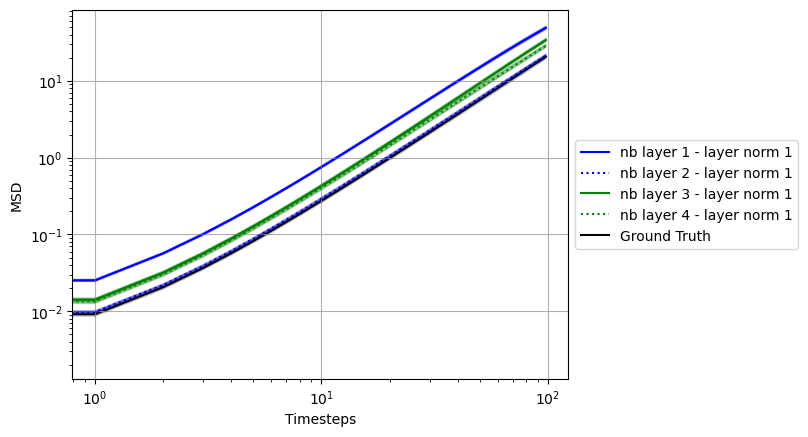

In [20]:
# plot of MSD

res_msd = []


for i in range(len(nb_layer_list)):
    print(MSD_list_normal[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_normal[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_normal[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], linestyle=styles[i], zorder = 1, label = labels_graphs[i])
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_normal[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.2, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSD-gnn-normal.png', bbox_inches='tight')
plt.show()


In [21]:
msd_gt = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)

for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 194.95588734517017 +- 234.86986858918337
l1: nb layer 2 - layer norm 1 >>>> 0.17099668903962975 +- 0.18058654623956155
l1: nb layer 3 - layer norm 1 >>>> 38.06978790385252 +- 49.89635129971016
l1: nb layer 4 - layer norm 1 >>>> 14.680525855130327 +- 18.18264649117551


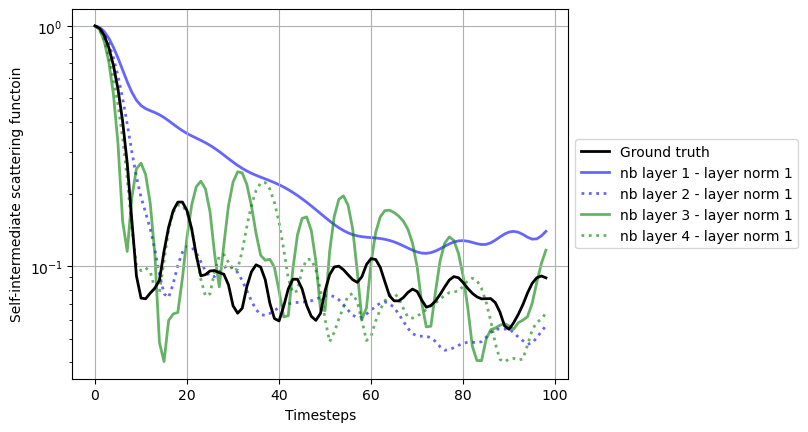

In [22]:
# plot of scat

res_scat = []

ssf_mean = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_normal[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth', zorder = 2)
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(nb_layer_list)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    res_scat.append(ssf_mean)
    ssf_std = np.std(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], linestyle=styles[i], lw=2, label = labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-gnn.png', bbox_inches='tight')
plt.show()


In [23]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.025118854203193153 +- 0.0377134993066509
l1: nb layer 2 - layer norm 1 >>>> 0.0017870376842271276 +- 0.003789296668492638
l1: nb layer 3 - layer norm 1 >>>> 0.006437971956468141 +- 0.010892198607351198
l1: nb layer 4 - layer norm 1 >>>> 0.0016751072019037959 +- 0.0036837085613440086


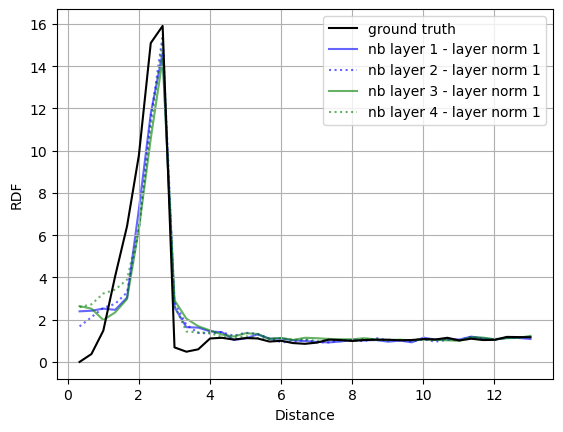

In [24]:
mean_res, std_res, r = RDF_base_normal
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4, zorder = 1)

for i in range(len(nb_layer_list)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_normal[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    res_rdf.append(mean_res)
    
    plt.plot(r, mean_res,color = colors[i], linestyle=styles[i], label =labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-gnn.png', bbox_inches='tight')
plt.show()

In [25]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 7.906671901241719 +- 28.198841120970275
l1: nb layer 2 - layer norm 1 >>>> 8.099129861500932 +- 30.531299518580116
l1: nb layer 3 - layer norm 1 >>>> 6.868951094475378 +- 25.536208969586315
l1: nb layer 4 - layer norm 1 >>>> 7.877772847319805 +- 29.15394830960518


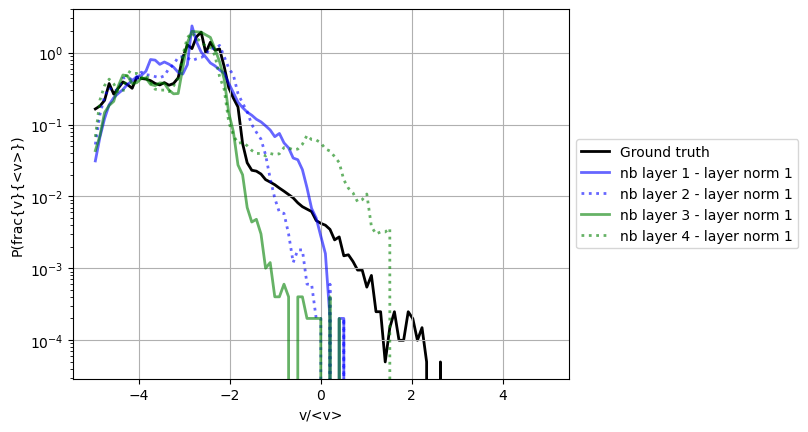

In [26]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    
    res_magn_distr.append(magn_base_mean)
    plt.semilogy(b[1:]-db/2,magn_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-gat.png', bbox_inches='tight')
plt.show()

In [27]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.04867337085831454 +- 0.1820251687840361
l1: nb layer 2 - layer norm 1 >>>> 0.030030794350378247 +- 0.13851489749335727
l1: nb layer 3 - layer norm 1 >>>> 0.019548503666091534 +- 0.09362645919069822
l1: nb layer 4 - layer norm 1 >>>> 0.01924099087806088 +- 0.07662443105415016


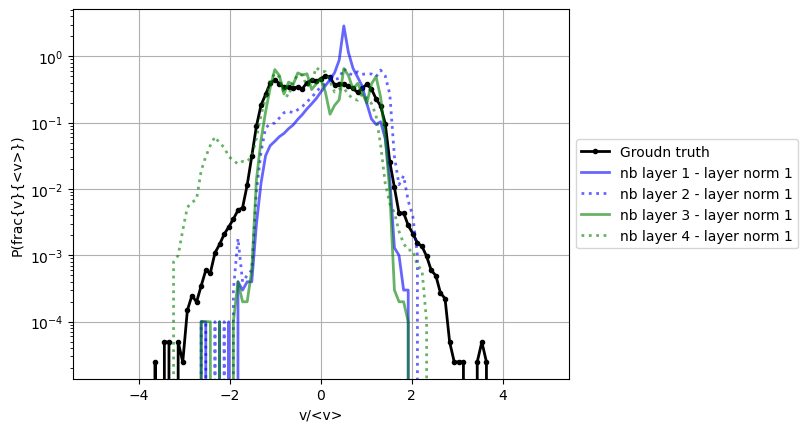

In [28]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    
    res_magn_x.append(x_base_mean)
    
    plt.semilogy(b[1:]-db/2,x_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig('speed-x-gnn.png', bbox_inches='tight')
plt.show()

In [29]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.08389983499478904 +- 0.619002609006058
l1: nb layer 2 - layer norm 1 >>>> 0.015176327722062047 +- 0.033551544686731334
l1: nb layer 3 - layer norm 1 >>>> 0.006911425697303182 +- 0.018326998533403024
l1: nb layer 4 - layer norm 1 >>>> 0.003478431578673274 +- 0.009043598325968223


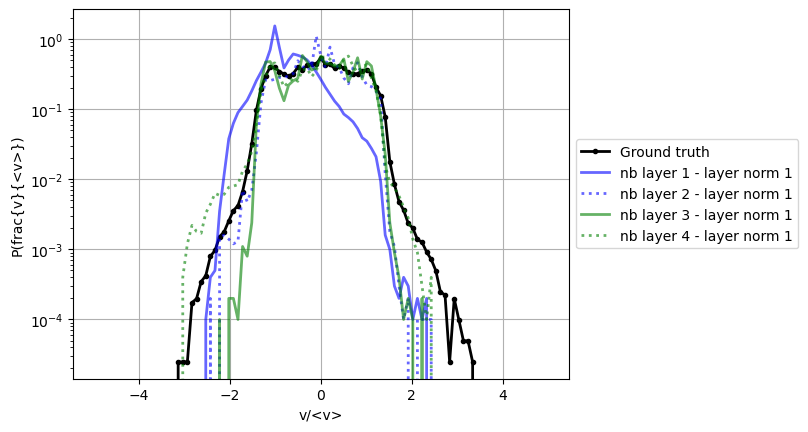

In [30]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    
    res_magn_y.append(y_base_mean)
    
    plt.semilogy(b[1:]-db/2,y_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-gat.png', bbox_inches='tight')
plt.show()

In [31]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.02969651294712056 +- 0.13409995637782415
l1: nb layer 2 - layer norm 1 >>>> 0.007275766980689343 +- 0.04542224522656027
l1: nb layer 3 - layer norm 1 >>>> 0.0029963393418954137 +- 0.008600662098568596
l1: nb layer 4 - layer norm 1 >>>> 0.002109305375160385 +- 0.006925424690304882


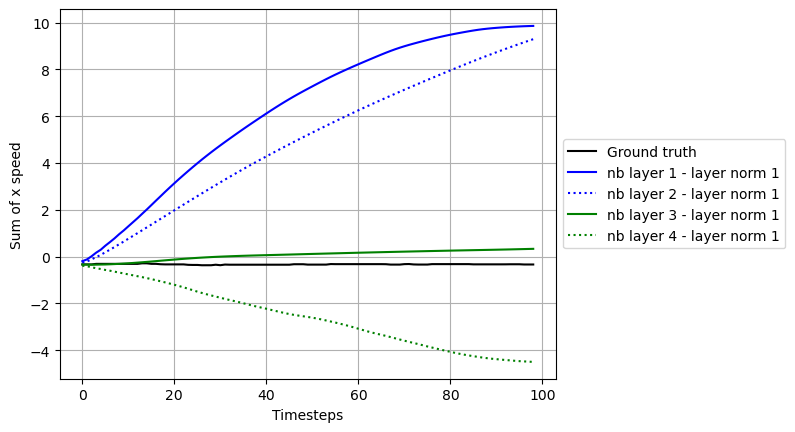

In [32]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-gnn.png', bbox_inches='tight')
plt.show()

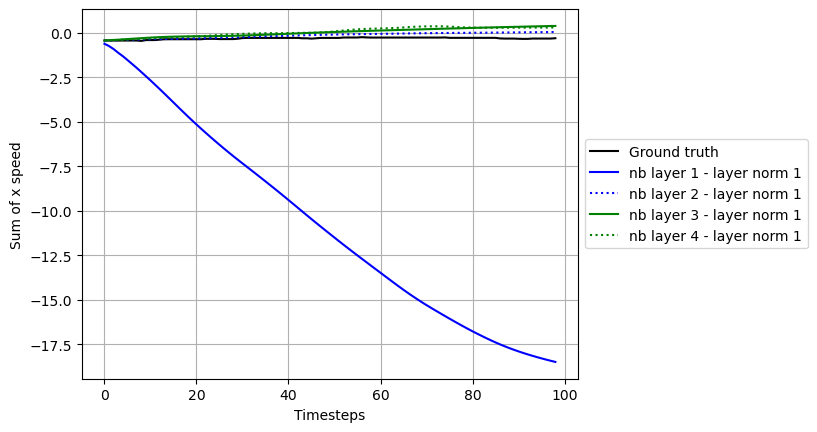

In [33]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-gnn.png', bbox_inches='tight')
plt.show()

# =======================
# =======================

In [34]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 400


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


#data_gt_1  = gen.get_mult_data(params1, NB_SIM)
#graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
#data_gt_list_1 = array2List(data_gt_1)


data_gt_2 = gen.get_mult_data(params2, NB_SIM)
graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
data_gt_list_2 = array2List(data_gt_2)

1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 48.53it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 48.73it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 48.97it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 49.00it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:07<00:00, 52.19it/s]


In [35]:
start = 250
length = 100

stop = start+length

In [36]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_noisy = stats.MSD_stat(data_gt_2[:, start:stop])
RDF_base_noisy  = stats.apply_rdf(data_gt_2[:, start:stop])
SCAT_base_noisy = stats.applySelfScattering(data_gt_2[:, start:stop])
DISTR_base_noisy = stats.apply_hist(data_gt_2, a, b)
SUM_base_noisy = stats.sumSpeeds(data_gt_2[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 76.23it/s]


In [37]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
#p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  5.21it/s]


In [38]:
MSD_list_noisy = []
RDF_list_noisy = []
SCAT_list_noisy = []
DISTR_list_noisy = []
SUM_list_noisy = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)


device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []






for i in tqdm(range(len(noisy_models_layers))):

    ## load model
    cfg = noisy_models_layers[i].cfg
    std_path = noisy_models_layers[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_2, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_2.copy()[:, start:stop])



    MSD_list_noisy.append(msd)
    RDF_list_noisy.append(rdf)
    SCAT_list_noisy.append(scat)
    DISTR_list_noisy.append(speed_distr)
    SUM_list_noisy.append(sum_speed)
    
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 212.65it/s]

100%|██████████| 99/99 [00:00<00:00, 195.88it/s]

100%|██████████| 99/99 [00:00<00:00, 201.72it/s]

100%|██████████| 99/99 [00:00<00:00, 192.15it/s]

100%|██████████| 99/99 [00:00<00:00, 195.63it/s]

100%|██████████| 100/100 [00:01<00:00, 74.06it/s][A

100%|██████████| 100/100 [00:01<00:00, 92.26it/s]

100%|██████████| 100/100 [00:00<00:00, 110.46it/s][A

100%|██████████| 100/100 [00:00<00:00, 115.53it/s][A

100%|██████████| 100/100 [00:01<00:00, 98.83it/s][A

 53%|█████▎    | 82/155 [00:46<00:39,  1.84it/s]


100%|██████████| 155/155 [01:25<00:00,  2.11it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 205.07it/s]

100%|██████████| 15/15 [00:00<00:00, 216.95it/s]

100%|██████████| 15/15 [00:00<00:00, 240.13it/s]

100%|██████████| 15/15 [00:00<00:00, 239.68it/s]

100%|██████████| 15/15 [00:00<00:00, 209.69it/s]

100%|██████████| 15/15 [00:00<00:00, 216.61it/s]

100%|██████████| 15/15 [00:00<00:00, 236.14it/s]

100%|██████████| 15/15 [00:00<00:00, 203.77it/s]

100%|██████████| 15/15 [00:00<00:00, 205.29it/s]

100%|██████████| 15/15 [00:00<00:00, 205.96it/s]

100%|██████████| 15/15 [00:00<00:00, 238.52it/s]

100%|██████████| 15/15 [00:00<00:00, 233.11it/s]

100%|██████████| 15/15 [00:00<00:00, 239.84it/s]

100%|██████████| 15/15 [00:00<00:00, 191.54it/s]

100%|██████████| 15/15 [00:00<00:00, 205.14it/s]

100%|██████████| 15/15 [00:00<00:00, 223.44it/s]

100%|██████████| 15/15 [00:00<00:00, 240.31it/s]

100%|██████████| 15/15 [00:00<00:00, 207.71it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 169.71it/s]

100%|██████████| 99/99 [00:00<00:00, 167.49it/s]

100%|██████████| 99/99 [00:00<00:00, 153.53it/s]

100%|██████████| 99/99 [00:00<00:00, 167.67it/s]

100%|██████████| 99/99 [00:00<00:00, 163.53it/s]

100%|██████████| 100/100 [00:01<00:00, 92.04it/s]

100%|██████████| 100/100 [00:00<00:00, 119.26it/s][A

100%|██████████| 100/100 [00:00<00:00, 111.59it/s][A

100%|██████████| 100/100 [00:00<00:00, 115.23it/s]

100%|██████████| 100/100 [00:00<00:00, 111.82it/s][A

 52%|█████▏    | 80/155 [00:45<00:43,  1.71it/s]


100%|██████████| 155/155 [01:26<00:00,  2.11it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 149.97it/s]

100%|██████████| 15/15 [00:00<00:00, 168.88it/s]

100%|██████████| 15/15 [00:00<00:00, 178.47it/s]

100%|██████████| 15/15 [00:00<00:00, 181.87it/s]

100%|██████████| 15/15 [00:00<00:00, 154.01it/s]

100%|██████████| 15/15 [00:00<00:00, 150.98it/s]

100%|██████████| 15/15 [00:00<00:00, 181.81it/s]

100%|██████████| 15/15 [00:00<00:00, 181.77it/s]

100%|██████████| 15/15 [00:00<00:00, 157.11it/s]

100%|██████████| 15/15 [00:00<00:00, 160.17it/s]

100%|██████████| 15/15 [00:00<00:00, 189.14it/s]

100%|██████████| 15/15 [00:00<00:00, 191.44it/s]

100%|██████████| 15/15 [00:00<00:00, 174.54it/s]

100%|██████████| 15/15 [00:00<00:00, 161.91it/s]

100%|██████████| 15/15 [00:00<00:00, 179.58it/s]

100%|██████████| 15/15 [00:00<00:00, 189.29it/s]

100%|██████████| 15/15 [00:00<00:00, 192.94it/s]

100%|██████████| 15/15 [00:00<00:00, 166.43it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 128.42it/s]

100%|██████████| 99/99 [00:00<00:00, 128.15it/s]

100%|██████████| 99/99 [00:00<00:00, 127.92it/s]

100%|██████████| 99/99 [00:00<00:00, 162.21it/s]

100%|██████████| 99/99 [00:00<00:00, 176.48it/s]

100%|██████████| 100/100 [00:00<00:00, 113.25it/s][A

100%|██████████| 100/100 [00:00<00:00, 112.16it/s][A

100%|██████████| 100/100 [00:00<00:00, 111.25it/s][A

100%|██████████| 100/100 [00:00<00:00, 115.50it/s]

100%|██████████| 100/100 [00:00<00:00, 110.51it/s][A

 49%|████▉     | 76/155 [00:44<00:43,  1.81it/s]


100%|██████████| 155/155 [01:29<00:00,  1.89it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 158.48it/s]

100%|██████████| 15/15 [00:00<00:00, 140.39it/s]

100%|██████████| 15/15 [00:00<00:00, 136.49it/s]

100%|██████████| 15/15 [00:00<00:00, 129.92it/s]

100%|██████████| 15/15 [00:00<00:00, 159.56it/s]

100%|██████████| 15/15 [00:00<00:00, 157.74it/s]

100%|██████████| 15/15 [00:00<00:00, 125.92it/s]

100%|██████████| 15/15 [00:00<00:00, 135.96it/s]

100%|██████████| 15/15 [00:00<00:00, 159.82it/s]

100%|██████████| 15/15 [00:00<00:00, 156.84it/s]

100%|██████████| 15/15 [00:00<00:00, 151.77it/s]

100%|██████████| 15/15 [00:00<00:00, 123.87it/s]

100%|██████████| 15/15 [00:00<00:00, 126.57it/s]

100%|██████████| 15/15 [00:00<00:00, 125.78it/s]

100%|██████████| 15/15 [00:00<00:00, 130.54it/s]

100%|██████████| 15/15 [00:00<00:00, 127.06it/s]

100%|██████████| 15/15 [00:00<00:00, 124.45it/s]

100%|██████████| 15/15 [00:00<00:00, 129.40it/s]



>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 105.18it/s]

100%|██████████| 99/99 [00:00<00:00, 131.85it/s]

100%|██████████| 99/99 [00:00<00:00, 147.78it/s]

100%|██████████| 99/99 [00:00<00:00, 150.44it/s]

100%|██████████| 99/99 [00:00<00:00, 149.13it/s]

100%|██████████| 100/100 [00:00<00:00, 112.80it/s][A

100%|██████████| 100/100 [00:00<00:00, 116.35it/s][A

100%|██████████| 100/100 [00:00<00:00, 113.71it/s][A

100%|██████████| 100/100 [00:00<00:00, 116.79it/s][A

100%|██████████| 100/100 [00:00<00:00, 111.39it/s][A

 50%|████▉     | 77/155 [00:45<00:54,  1.43it/s]


100%|██████████| 155/155 [01:31<00:00,  1.75it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 200.27it/s]

100%|██████████| 15/15 [00:00<00:00, 200.88it/s]

100%|██████████| 15/15 [00:00<00:00, 203.47it/s]

100%|██████████| 15/15 [00:00<00:00, 201.45it/s]

100%|██████████| 15/15 [00:00<00:00, 196.56it/s]

100%|██████████| 15/15 [00:00<00:00, 204.37it/s]

100%|██████████| 15/15 [00:00<00:00, 207.11it/s]

100%|██████████| 15/15 [00:00<00:00, 205.38it/s]

100%|██████████| 15/15 [00:00<00:00, 203.37it/s]

100%|██████████| 15/15 [00:00<00:00, 206.74it/s]

100%|██████████| 15/15 [00:00<00:00, 204.61it/s]

100%|██████████| 15/15 [00:00<00:00, 202.86it/s]

100%|██████████| 15/15 [00:00<00:00, 204.01it/s]

100%|██████████| 15/15 [00:00<00:00, 202.31it/s]

100%|██████████| 15/15 [00:00<00:00, 195.92it/s]

100%|██████████| 15/15 [00:00<00:00, 189.41it/s]

100%|██████████| 15/15 [00:00<00:00, 204.12it/s]

100%|██████████| 15/15 [00:00<00:00, 203.12it/s]



In [39]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.0009521437910893491, 0.0009234633845689728, 0.0009914141625527288, 0.001089176514554701]
errors std ==> [0.0013817305578992295, 0.001405570182708704, 0.0017404496766065339, 0.0017525687725887728]
angle_error ==>  [0.12348662, 0.13020846, 0.12973908, 0.1302717]
angle_std std ==> [0.12348662, 0.13020846, 0.12973908, 0.1302717]
norm_errors_list ==>  [0.0005436241626739502, 0.00042902748100459576, 0.00040620937943458557, 0.000628296285867691]
norm_errors_std_list std ==> [0.0012954825906380844, 0.0013480106974001062, 0.001874639147749218, 0.0018611976599964234]
sim_error_list ==>  [0.0371010605355057, 0.033916348943228265, 0.03543589382476224, 0.03995170683156893]
sim_error_std_list std ==> [0.0025031583872178517, 0.002631589096025341, 0.002526275293413008, 0.002560814069552849]


In [40]:
nb_layer_list = [noisy_models_layers[i].nbLayer for i in range(len(noisy_models_layers))]
# layer norm
print(nb_layer_list)

[1, 2, 3, 4]


In [41]:
labels_graphs = [f'nb layer {normal_models_layers[i].nbLayer} - layer norm {noisy_models_layers[i].layerNorm}' for i in range(len(noisy_models_layers))]
print(labels_graphs)

['nb layer 1 - layer norm 1', 'nb layer 2 - layer norm 1', 'nb layer 3 - layer norm 1', 'nb layer 4 - layer norm 1']


In [42]:
colors = ['blue','blue', 'green', 'green', 'orange','orange', 'red', 'red']
styles = ['solid', 'dotted', 'solid', 'dotted', 'solid', 'dotted', 'solid', 'dotted']

In [43]:
limit_scat = 99
limit_msd = 99


(5, 99)
(5, 99)
(5, 99)
(5, 99)


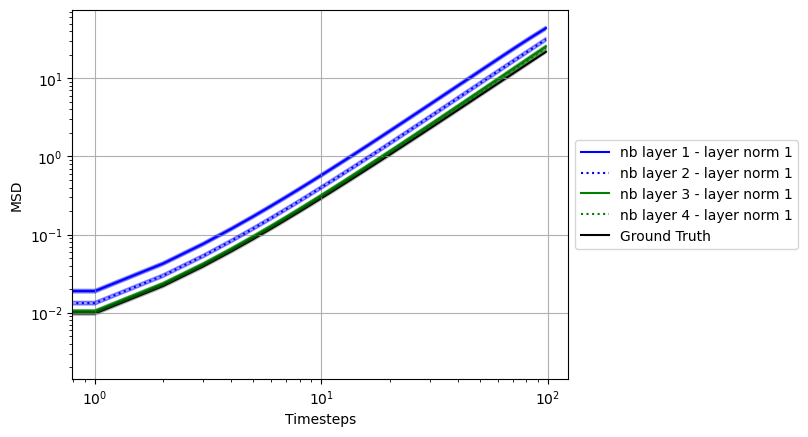

In [44]:
# plot of MSD

res_msd = []


for i in range(len(nb_layer_list)):
    print(MSD_list_noisy[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], linestyle=styles[i], zorder = 1, label = labels_graphs[i])
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_noisy[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.2, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSD-gnn-noisy.png', bbox_inches='tight')
plt.show()


In [45]:
msd_gt = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)

for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 106.1667024927593 +- 135.64957000101273
l1: nb layer 2 - layer norm 1 >>>> 19.050878294149218 +- 25.20802745496775
l1: nb layer 3 - layer norm 1 >>>> 2.4401530560843483 +- 3.531198237579141
l1: nb layer 4 - layer norm 1 >>>> 1.16752961145993 +- 1.5951499744133484


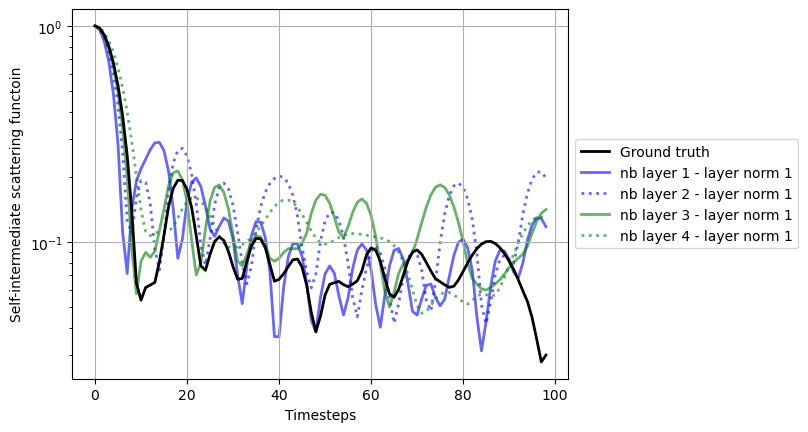

In [46]:
# plot of scat

res_scat = []


ssf_mean = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_noisy[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth', zorder = 2)
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(nb_layer_list)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], linestyle=styles[i], lw=2, label = labels_graphs[i], alpha = 0.6, zorder = 1)
    res_scat.append(ssf_mean)

    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-gnn-noisy.png', bbox_inches='tight')
plt.show()


In [47]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.005457311643965568 +- 0.013926052361637407
l1: nb layer 2 - layer norm 1 >>>> 0.00403534495967048 +- 0.005393125232065732
l1: nb layer 3 - layer norm 1 >>>> 0.0018853149215928605 +- 0.0028161163741695834
l1: nb layer 4 - layer norm 1 >>>> 0.0019228375737718264 +- 0.003328892914664507


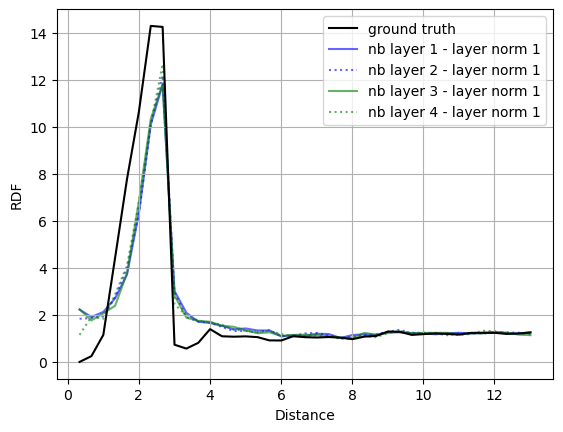

In [48]:
mean_res, std_res, r = RDF_base_noisy
lim_rdf = 40

res_rdf = []

mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4, zorder = 1)

for i in range(len(nb_layer_list)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_noisy[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    res_rdf.append(mean_res)

    
    plt.plot(r, mean_res,color = colors[i], linestyle=styles[i], label =labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-gnn-noisy.png', bbox_inches='tight')
plt.show()

In [49]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 5.1459315516594755 +- 17.41939131262143
l1: nb layer 2 - layer norm 1 >>>> 5.387616383497884 +- 18.425212140920994
l1: nb layer 3 - layer norm 1 >>>> 5.386450386746483 +- 17.92527510060648
l1: nb layer 4 - layer norm 1 >>>> 5.785085917089319 +- 19.82275229703762


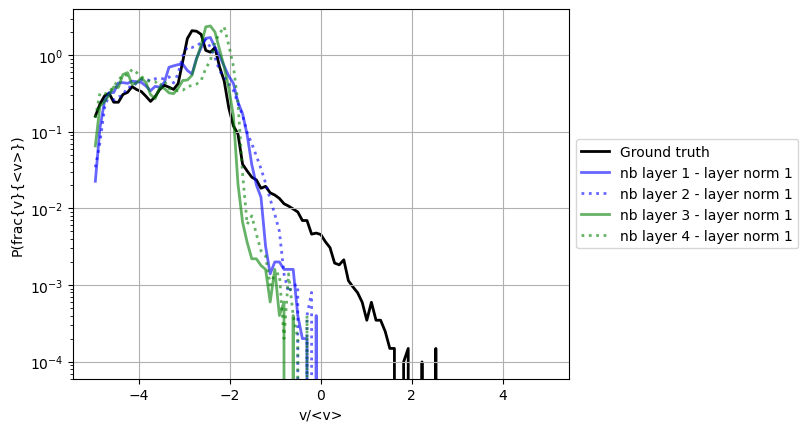

In [50]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)


res_magn_distr = []



fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    
    res_magn_distr.append(magn_base_mean)

    plt.semilogy(b[1:]-db/2,magn_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-gnn-noisy.png', bbox_inches='tight')
plt.show()

In [51]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.02941283598780516 +- 0.10047210087410632
l1: nb layer 2 - layer norm 1 >>>> 0.01241721606527144 +- 0.04906444648509372
l1: nb layer 3 - layer norm 1 >>>> 0.060303075629333236 +- 0.23947443928126205
l1: nb layer 4 - layer norm 1 >>>> 0.1112852193462013 +- 0.41411591137029147


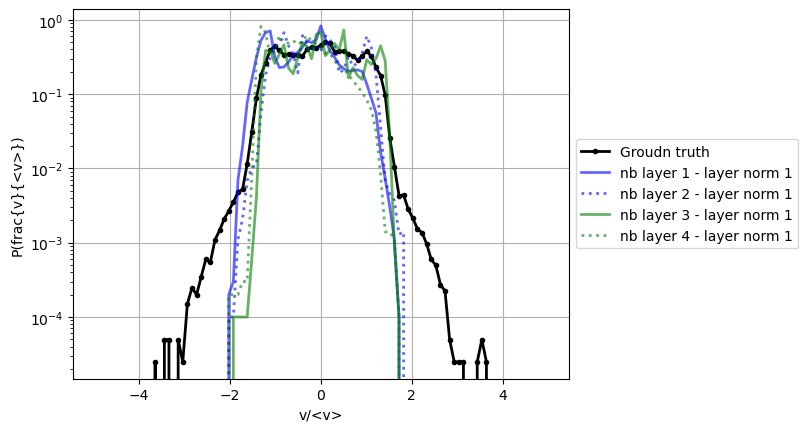

In [52]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []



fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    
    res_magn_x.append(x_base_mean)
    plt.semilogy(b[1:]-db/2,x_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig('speed-x-gnn-noisy.png', bbox_inches='tight')
plt.show()

In [53]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.010033997599786678 +- 0.027764166349315268
l1: nb layer 2 - layer norm 1 >>>> 0.004872917379539067 +- 0.015498948024857902
l1: nb layer 3 - layer norm 1 >>>> 0.006574974337084436 +- 0.017365292282639295
l1: nb layer 4 - layer norm 1 >>>> 0.013477349066331802 +- 0.0456807433692493


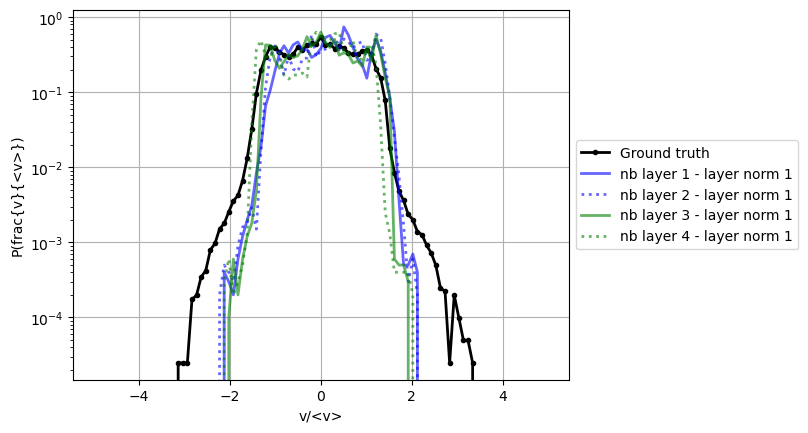

In [54]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []



fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    res_magn_y.append(y_base_mean)

    plt.semilogy(b[1:]-db/2,y_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-gnn-noisy.png', bbox_inches='tight')
plt.show()

In [55]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.007633870260100016 +- 0.02057354016531327
l1: nb layer 2 - layer norm 1 >>>> 0.006891534157722885 +- 0.021907970998368095
l1: nb layer 3 - layer norm 1 >>>> 0.003555444501764803 +- 0.014139704633936833
l1: nb layer 4 - layer norm 1 >>>> 0.006139303107369702 +- 0.016258112564001535


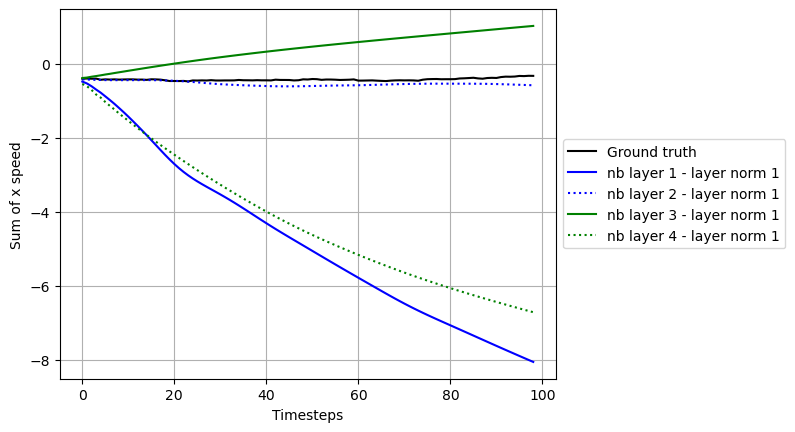

In [56]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-gnn-noisy.png', bbox_inches='tight')
plt.show()

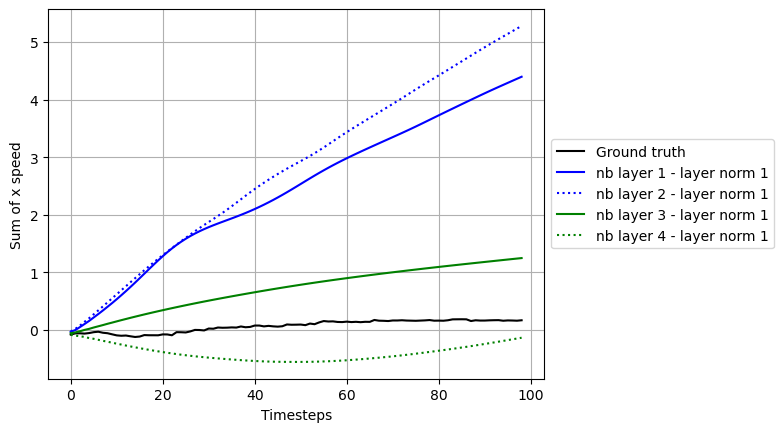

In [57]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-y-gnn-noisy.png', bbox_inches='tight')
plt.show()

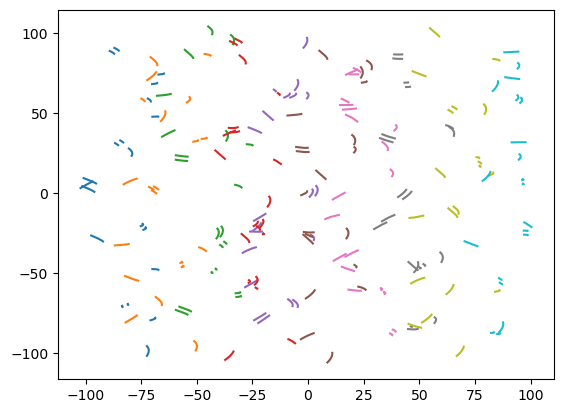

In [58]:
plt.plot(data_pred[0][:, :, 0], data_pred[0][:, :, 1])

In [59]:
data_gt_2.copy()[:, start:stop]

array([[[[-70.84999921, -79.64297486],
         [-65.65394341, -70.00898837],
         [-52.58283113, -74.03969281],
         ...,
         [ 42.35098817,  86.79565102],
         [ 83.21829871,  83.97254683],
         [ 94.55235047,  88.56445975]],

        [[-70.79429895, -79.62067057],
         [-65.65268925, -69.94900148],
         [-52.61915916, -74.01173526],
         ...,
         [ 42.327593  ,  86.79635152],
         [ 83.27730087,  83.96164978],
         [ 94.49246973,  88.56067852]],

        [[-70.73832425, -79.59906425],
         [-65.64863172, -69.88913883],
         [-52.65528841, -73.98373157],
         ...,
         [ 42.30296005,  86.79665825],
         [ 83.33612878,  83.94984822],
         [ 94.43247704,  88.55974182]],

        ...,

        [[-65.42495779, -77.53797985],
         [-65.48776031, -64.1921489 ],
         [-56.07288705, -71.28676294],
         ...,
         [ 40.14602453,  86.89663545],
         [ 88.93239389,  82.87168742],
         [ 88.74064497,  88

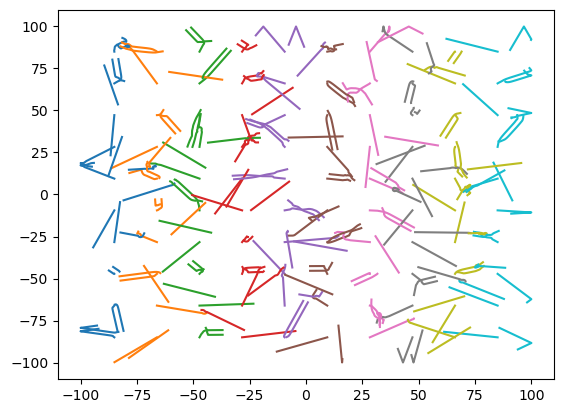

In [60]:
plt.plot(data_gt_1[0][:, :, 0], data_gt_1[0][:, :, 1])